In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
df.shape

(1511, 6)

In [5]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
mic_stock_data = df[['Date','Open','Close']]
mic_stock_data['Date'] = pd.to_datetime(mic_stock_data['Date'].apply(lambda x: x.split(' ')[0]))
mic_stock_data.set_index('Date',drop=True,inplace=True) # Setting date column as index

In [7]:
mic_stock_data.head()

,Open,Close
Date,,
2015-04-01,40.60,40.72
2015-04-02,40.66,40.29
2015-04-06,40.34,41.55
2015-04-07,41.61,41.53
2015-04-08,41.48,41.42


In [8]:
mic_stock_data.tail()

,Open,Close
Date,,
2021-03-25,235.30,232.34
2021-03-26,231.55,236.48
2021-03-29,236.59,235.24
2021-03-30,233.53,231.85
2021-03-31,232.91,235.77


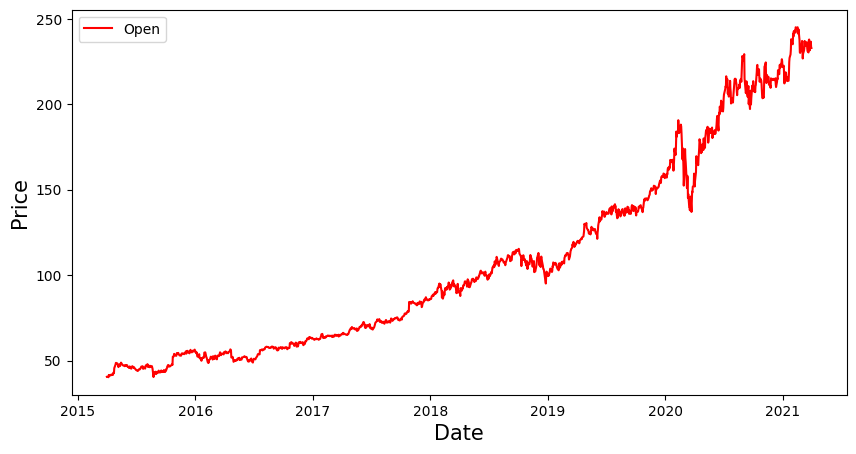

In [9]:
plt.figure(figsize = (10, 5))
plt.plot(mic_stock_data['Open'],label='Open',color='red')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend()
plt.show()

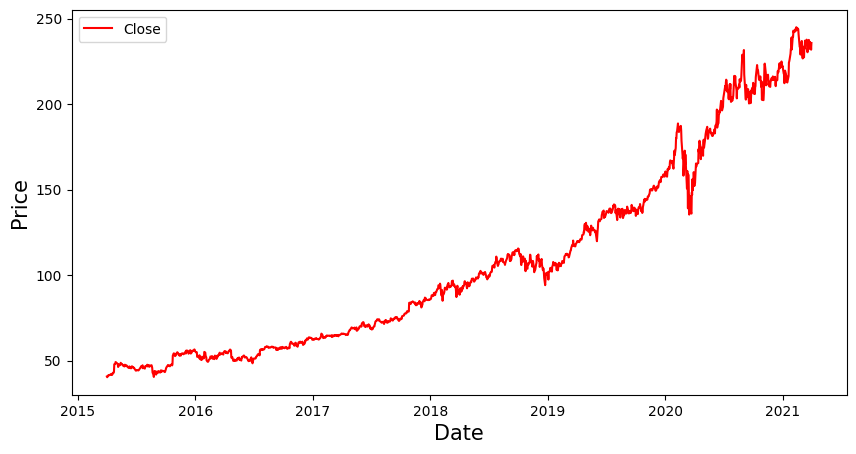

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(mic_stock_data['Close'],label='Close',color='red')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend()
plt.show()

# Data Pre-Processing

In [11]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
mic_stock_data[mic_stock_data.columns] = MMS.fit_transform(mic_stock_data)

In [12]:
mic_stock_data.shape

(1511, 2)

### Splitting train and test data

In [13]:
training_size = round(len(mic_stock_data) * 0.80) 
train_data = mic_stock_data[:training_size]
test_data  = mic_stock_data[training_size:]

train_data.shape, test_data.shape

((1209, 2), (302, 2))

### Function to create sequence of data for training and testing

In [14]:
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(60,len(dataset)): # Selecting 60 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [15]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [16]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((1149, 60, 2), (1149, 2), (242, 60, 2), (242, 2))

In [17]:
train_label

array([[0.02594167, 0.02427943],
       [0.02296155, 0.01993161],
       [0.02134936, 0.01885686],
       ...,
       [0.59739118, 0.60034196],
       [0.60584298, 0.61494871],
       [0.62084127, 0.61949194]])

# Creating LSTM model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

2024-02-19 22:51:48.399764: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 22:51:48.449585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 22:51:48.449660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 22:51:48.451900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 22:51:48.463292: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 22:51:48.464120: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [19]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

2024-02-19 22:51:54.028867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 22:51:54.035061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
36/36 [==============================] - 5s 57ms/step - loss: 0.0047 - mean_absolute_error: 0.0450 - val_loss: 0.0128 - val_mean_absolute_error: 0.1034
Epoch 2/80
36/36 [==============================] - 1s 34ms/step - loss: 2.6055e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0046 - val_mean_absolute_error: 0.0583
Epoch 3/80
36/36 [==============================] - 1s 34ms/step - loss: 1.8552e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0034 - val_mean_absolute_error: 0.0488
Epoch 4/80
36/36 [==============================] - 1s 35ms/step - loss: 1.8582e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0032 - val_mean_absolute_error: 0.0473
Epoch 5/80
36/36 [==============================] - 1s 37ms/step - loss: 1.9212e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0029 - val_mean_absolute_error: 0.0443
Epoch 6/80
36/36 [==============================] - 1s 37ms/step - loss: 1.7885e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0020 - val_mean_absolute_error: 0.0352
Ep

In [21]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

8/8 [==============================] - 1s 15ms/step


array([[0.6279403 , 0.6251534 ],
       [0.63861203, 0.6358453 ],
       [0.65066975, 0.6480294 ],
       [0.65781796, 0.65489423],
       [0.6562958 , 0.6525601 ]], dtype=float32)

In [22]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[168.87311, 168.2589 ],
       [171.0575 , 170.44753],
       [173.52559, 172.94162],
       [174.98875, 174.34685],
       [174.67719, 173.86905]], dtype=float32)

# Visualization of Predicted Data¶

In [23]:
# Merging actual and predicted data for better visualization

mic_slic_data = pd.concat([mic_stock_data.iloc[-242:].copy(),
                          pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],
                          index=mic_stock_data.iloc[-242:].index)],
                          axis=1)

In [24]:
mic_slic_data[['open','close']] = MMS.inverse_transform(mic_slic_data[['Open','Close']]) # Inverse scaling

In [25]:
mic_slic_data.head()

,Open,Close,open_predicted,close_predicted,open,close
Date,,,,,,
2020-04-16,0.654453,0.668051,168.873108,168.258896,174.30,177.04
2020-04-17,0.679857,0.675672,171.057495,170.447525,179.50,178.60
2020-04-20,0.665836,0.658378,173.525589,172.941620,176.63,175.06
2020-04-21,0.650545,0.623009,174.988754,174.346848,173.50,167.82
2020-04-22,0.640236,0.650855,174.677185,173.869049,171.39,173.52


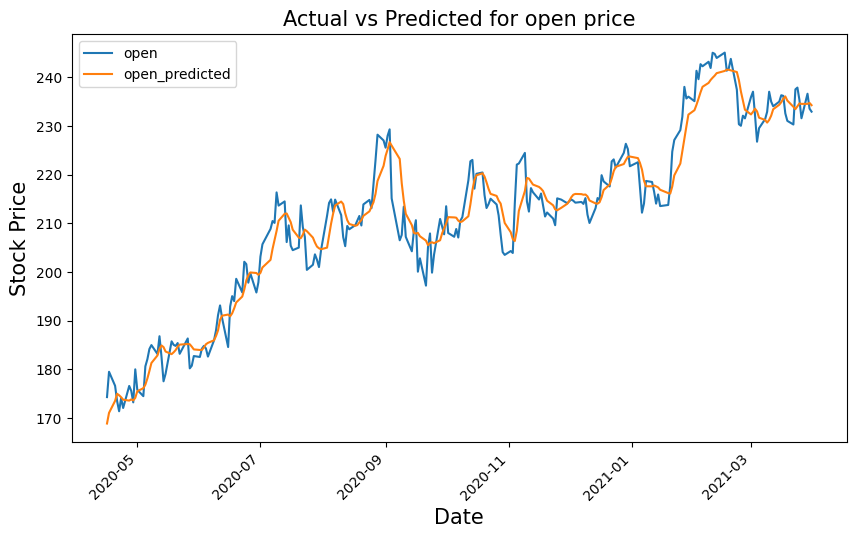

In [26]:
mic_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

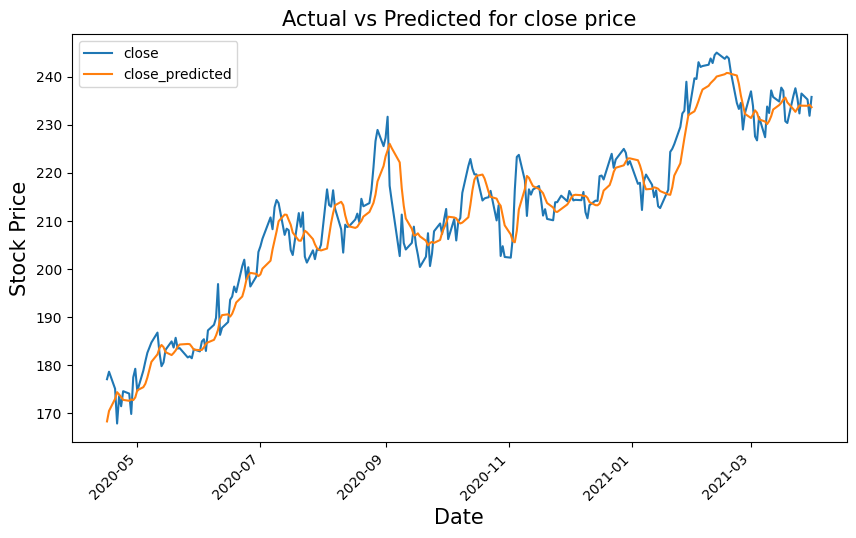

In [27]:
mic_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# Predicting upcoming 30 days

In [28]:
mic_slic_data

,Open,Close,open_predicted,close_predicted,open,close
Date,,,,,,
2020-04-16,0.654453,0.668051,168.873108,168.258896,174.30,177.04
2020-04-17,0.679857,0.675672,171.057495,170.447525,179.50,178.60
2020-04-20,0.665836,0.658378,173.525589,172.941620,176.63,175.06
2020-04-21,0.650545,0.623009,174.988754,174.346848,173.50,167.82
2020-04-22,0.640236,0.650855,174.677185,173.869049,171.39,173.52
...,...,...,...,...,...,...
2021-03-25,0.952465,0.938202,234.599396,234.026932,235.30,232.34
2021-03-26,0.934144,0.958427,234.505569,233.952774,231.55,236.48
2021-03-29,0.958767,0.952369,234.504150,233.927643,236.59,235.24


In [29]:
new_data = pd.DataFrame(columns=mic_slic_data.columns,
                            index=pd.date_range(start=mic_slic_data.index[-1], periods=31, freq='D'))
mic_slic_data = pd.concat([mic_slic_data, new_data])

In [33]:
mic_slic_data

,Open,Close,open_predicted,close_predicted,open,close
2020-04-16,0.654453,0.668051,168.873108,168.258896,174.30,177.04
2020-04-17,0.679857,0.675672,171.057495,170.447525,179.50,178.60
2020-04-20,0.665836,0.658378,173.525589,172.941620,176.63,175.06
2020-04-21,0.650545,0.623009,174.988754,174.346848,173.50,167.82
2020-04-22,0.640236,0.650855,174.677185,173.869049,171.39,173.52
...,...,...,...,...,...,...
2021-04-26,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-27,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-28,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
future_prediction = pd.DataFrame(columns=['Open','Close'],index=mic_slic_data.index)
future_prediction.index=pd.to_datetime(future_prediction.index)

In [36]:
future_prediction

,Open,Close
2020-04-16,NaN,NaN
2020-04-17,NaN,NaN
2020-04-20,NaN,NaN
2020-04-21,NaN,NaN
2020-04-22,NaN,NaN
...,...,...
2021-04-26,NaN,NaN
2021-04-27,NaN,NaN
2021-04-28,NaN,NaN
2021-04-29,NaN,NaN


In [37]:
curr_seq = test_seq[-1:]

for i in range(-30,0):
  up_pred = model.predict(curr_seq)
  future_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 21ms/step


In [38]:
future_prediction[['Open','Close']] = MMS.inverse_transform(future_prediction[['Open','Close']])

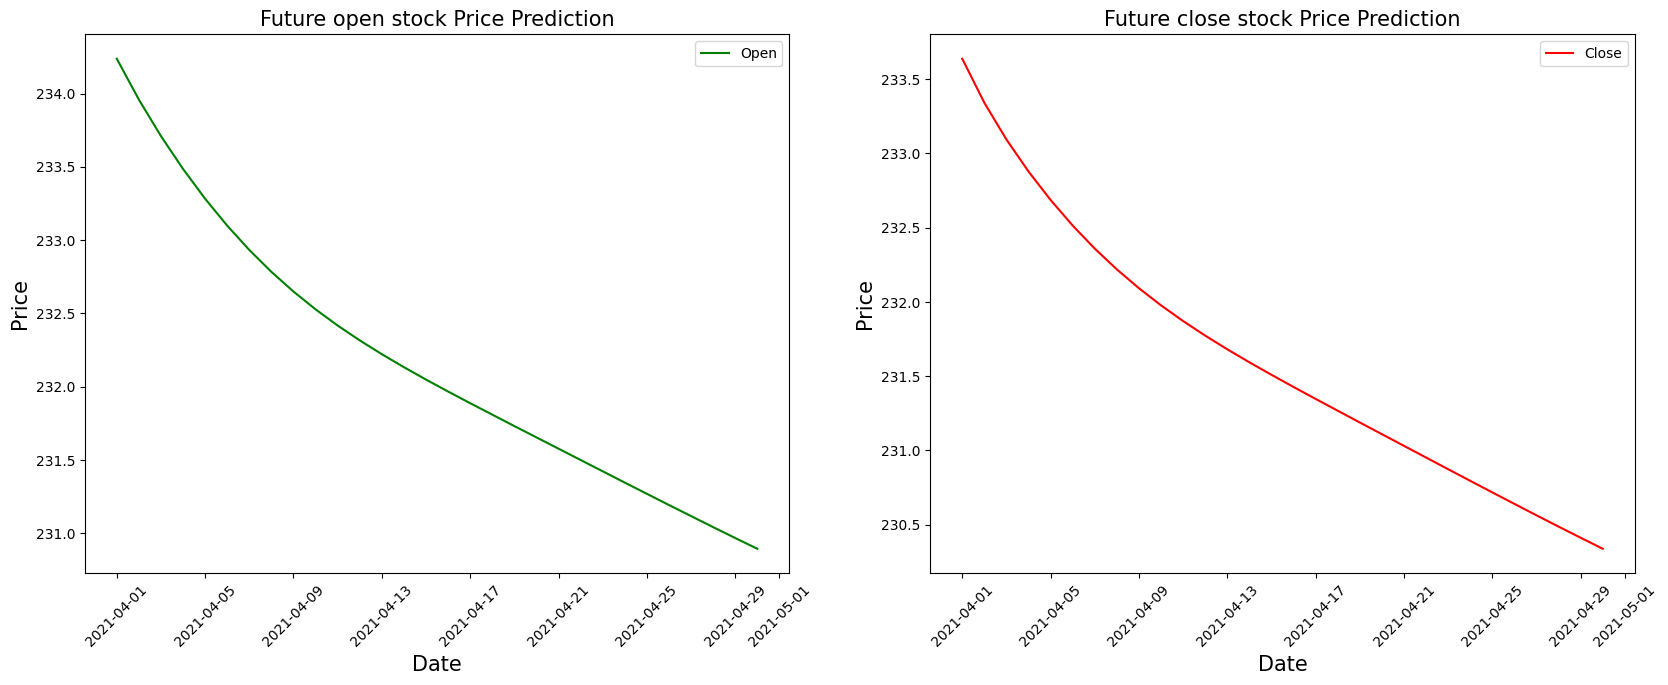

In [39]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
# First Subplot
ax[0].plot(future_prediction['Open'], label='Open', color='green')
ax[0].set_title('Future open stock Price Prediction', size=15) 
ax[0].set_xlabel('Date', size=15)
ax[0].set_ylabel('Price', size=15)
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Second Subplot
ax[1].plot(future_prediction['Close'], label='Close', color='red')
ax[1].set_title('Future close stock Price Prediction', size=15) 
ax[1].set_xlabel('Date', size=15)
ax[1].set_ylabel('Price', size=15)
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

plt.show()

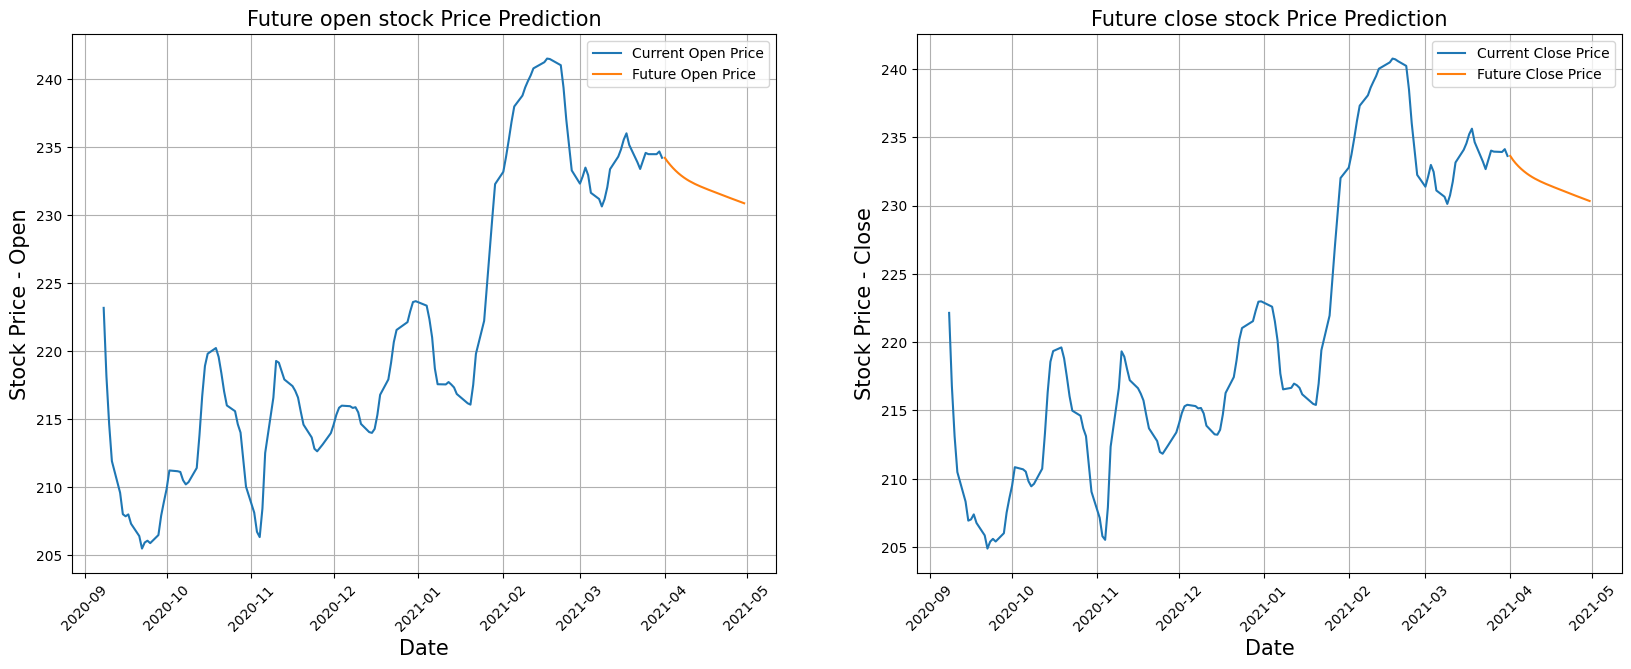

In [41]:
fg, ax =plt.subplots(1,2,figsize=(20,7))

# Plot open prices
ax[0].plot(mic_slic_data.loc['2020-09-07':, 'open_predicted'], label='Current Open Price')
ax[0].plot(future_prediction['Open'], label='Future Open Price')
ax[0].set_title('Future open stock Price Prediction', size=15) 
ax[0].set_xlabel('Date', size=15)
ax[0].set_ylabel('Stock Price - Open', size=15)
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x', rotation=45)

# Plot close prices
ax[1].plot(mic_slic_data.loc['2020-09-07':, 'close_predicted'], label='Current Close Price')
ax[1].plot(future_prediction['Close'], label='Future Close Price')
ax[1].set_title('Future close stock Price Prediction', size=15)
ax[1].set_xlabel('Date', size=15)
ax[1].set_ylabel('Stock Price - Close', size=15)
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x', rotation=45)

# Display the plot
plt.show()